# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [124]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
175,a68025486E,Kia Rio X-line,economy,petrol,3.82,2013,44337,2017,25.35,electro_bug
2321,e40587429i,Skoda Rapid,economy,petrol,3.64,2017,125757,2018,42.03,gear_stick
806,v-1935966T,Hyundai Solaris,economy,petrol,4.70,2012,22882,2017,43.95,engine_overheat
1686,W-1536006u,Renault Sandero,standart,petrol,4.84,2014,64523,2021,37.03,engine_fuel
1392,U19913900a,Kia Rio,economy,petrol,4.38,2012,21139,2018,34.20,break_bug


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [125]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
230142,w95907350L,Q-1888317Y,p1u,2020-03-01,2.49,79,1101,76,149.017577,2,3404.581482,0,-4.195618,-5.780
663082,x10399607s,u22457924s,e1y,2020-03-16,5.44,33,356,44,75.000000,1,952.562621,0,1.153008,-10.002
135758,J12815306n,J15476551r,I1M,2020-01-21,6.80,157,2191,46,60.699899,0,215.704204,0,-4.036790,-0.000
326062,X14976161f,X-2032215W,m1c,2020-03-25,2.88,78,1009,39,96.000000,1,2071.778926,0,-0.844219,-27.873
428432,Q69268694t,e-4777482n,s1E,2020-01-24,2.53,196,2345,42,76.000000,14,2037.895039,0,2.293223,-10.593


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [126]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
12748,29,8.1,1847,8.0,I13414407w,1,2018-4-18
2041,41,8.6,1575,11.0,I14835984M,0,2021-6-27
10846,29,8.8,869,15.0,E99024906u,1,2019-4-1
7362,32,7.0,1438,4.0,T19970480A,0,2021-5-22
1353,33,6.8,1180,2.0,s58681928b,1,2020-12-19


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [127]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
29531,d-2262674v,XZ,2019-10-11 16:27,refuel,8.0,34
36089,s18773736B,WC,2020-12-22 15:3,reparking,1.0,33
127946,w-1247054B,YV,2019-11-24 11:57,reparking,1.0,27
100157,j-2299409Z,HT,2019-4-5 5:3,reparking,1.0,22
124642,a61936474Y,WY,2020-6-2 1:45,reparking,1.0,18


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

## **Решение 1 задания**

### Для каждой машины (то есть для каждого car_id) подсчитайте несколько признаков:

- минимальный рейтинг за все поездки;
- средний рейтинг за все поездки;
- общее количество километров, которое машина проехала;
- максимальная скорость;
- общее количество поездок для каждой машины.

In [128]:
group_of_rides = rides_info.groupby('car_id', as_index=False).agg(
    min_rating = ('rating', 'min'),
    mean_rating = ('rating', 'mean'),
    sum_distance = ('distance', 'sum'),
    speed_max = ('speed_max', 'max'),
    count_rides = ('ride_id', 'count')
)

In [129]:
group_of_rides.head()

,car_id,min_rating,mean_rating,sum_distance,speed_max,count_rides
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174
1,A-1079539w,0.1,4.088046,1.912765e+07,184.505566,174
2,A-1162143G,0.1,4.662299,2.995194e+06,180.000000,174
3,A-1228282M,0.1,4.225172,1.793685e+07,182.446070,174
4,A-1339912r,0.1,4.690115,1.202552e+07,152.000000,174


### Добавьте минимум 3 признака на свой выбор.

In [130]:
group_of_rides = rides_info.groupby('car_id', as_index=False).agg(
    min_rating = ('rating', 'min'),
    mean_rating = ('rating', 'mean'),
    sum_distance = ('distance', 'sum'),
    speed_max = ('speed_max', 'max'),
    count_rides = ('ride_id', 'count'),

    speed_mean = ('speed_avg', 'mean'),
    user_ride_quality_max = ('user_ride_quality', 'max'),
    ride_cost_mean = ('ride_cost', 'mean'),
)

In [131]:
group_of_rides.head()

,car_id,min_rating,mean_rating,sum_distance,speed_max,count_rides,speed_mean,user_ride_quality_max,ride_cost_mean
0,A-1049127W,0.1,4.255172,1.125753e+07,179.729652,174,49.459770,8.556052,15201.436782
1,A-1079539w,0.1,4.088046,1.912765e+07,184.505566,174,49.591954,19.324837,27007.477011
2,A-1162143G,0.1,4.662299,2.995194e+06,180.000000,174,43.448276,10.915018,4599.678161
3,A-1228282M,0.1,4.225172,1.793685e+07,182.446070,174,49.379310,4.188281,27379.522989
4,A-1339912r,0.1,4.690115,1.202552e+07,152.000000,174,44.149425,1.038861,16185.545977


### Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

In [132]:
df = pd.merge(car_train, group_of_rides, on='car_id')

In [133]:
df.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,sum_distance,speed_max,count_rides,speed_mean,user_ride_quality_max,ride_cost_mean
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,1.214131e+07,180.855726,174,44.660920,11.035871,20106.873563
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.0,4.480517,1.803909e+07,187.862734,174,49.862069,32.610351,26813.614943
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.1,4.768391,1.588366e+07,102.382857,174,44.005747,11.766087,23987.793103
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.1,3.880920,1.651883e+07,172.793237,174,49.344828,3.931040,37839.086207
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.1,4.181149,1.398317e+07,203.462289,174,50.603448,3.344463,19888.431034


### Подключите информацию про водителей (driver_info) и про ремонт машин (fix_info). Добавьте минимум 3 любых признака с каждого датасета.

In [12]:
# driver_info.head(1)

In [13]:
# fix_info.head(1)

In [14]:
# df = pd.merge(df, rides_info, on='car_id')
# df = pd.merge(df, driver_info[['user_id', 'age', 'user_rides', 'user_rating']], on='user_id')
# df = pd.merge(df, fix_info[['car_id', 'fix_date', 'work_type', 'work_duration']], on='car_id')

In [15]:
# df.head()

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

## **Решение 2 задания**

<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).

In [134]:
cols_for_delete = [col for col in df.columns if df[col].nunique() == 1
                   or df[col].nunique() == df.shape[0]
                   or col in ['ride_id', 'car_id', 'user_id']]

In [135]:
cols_for_delete

['car_id',
 'sum_distance',
 'count_rides',
 'user_ride_quality_max',
 'ride_cost_mean']

In [136]:
df = df.drop(columns=cols_for_delete)

In [137]:
df.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,speed_max,speed_mean
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,180.855726,44.660920
1,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.0,4.480517,187.862734,49.862069
2,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.1,4.768391,102.382857,44.005747
3,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.1,3.880920,172.793237,49.344828
4,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.1,4.181149,203.462289,50.603448


In [138]:
df.shape

(2337, 13)

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   model          2337 non-null   object 
 1   car_type       2337 non-null   object 
 2   fuel_type      2337 non-null   object 
 3   car_rating     2337 non-null   float64
 4   year_to_start  2337 non-null   int64  
 5   riders         2337 non-null   int64  
 6   year_to_work   2337 non-null   int64  
 7   target_reg     2337 non-null   float64
 8   target_class   2337 non-null   object 
 9   min_rating     2337 non-null   float64
 10  mean_rating    2337 non-null   float64
 11  speed_max      2337 non-null   float64
 12  speed_mean     2337 non-null   float64
dtypes: float64(6), int64(3), object(4)
memory usage: 255.6+ KB


### Линейная корреляция

In [ ]:
# df.corr()

# **У меня переполняется оперативная память при применении функции `df.corr()` из-за большого количества данных, поэтому я перезапустил первые несколько ячеек без merge. Но само первое задание выполнил.**

In [ ]:
# df.shape

In [ ]:
# df.corr()

In [ ]:
# plt.figure(figsize=(16, 10))
# sns.heatmap(df.corr(), annot=True)
# plt.show();

### Phik

In [ ]:
# !pip install phik

In [ ]:
# import phik
# from phik import report

In [ ]:
# phik_matrix = df.phik_matrix()

In [ ]:
# print(phik_matrix)

In [ ]:
# plt.figure(figsize=(16, 10))
# sns.heatmap(phik_matrix, annot=True)
# plt.show();

### Permutation importance

In [ ]:
# Нужна обученная модель, возьму для обучения решающее дерево
# from sklearn.ensemble import RandomForestClassifier

In [ ]:
# df.head()

In [ ]:
# df['model'].unique()

In [ ]:
# df['fuel_type'].unique()

In [ ]:
# !pip install category_encoders

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# import category_encoders as ce

# ohe = OneHotEncoder(sparse=False)
# be = ce.BinaryEncoder()

# categorical_cols = df.select_dtypes(include=['object']).columns

In [ ]:
# categorical_cols

In [ ]:
# for col in categorical_cols:
#     if df[col].nunique() <= 2:
#       print(col)

In [ ]:
# categorical_cols

Для столбцов, где больше 2 уникальных значений применяю BinaryEncoding, а для тех, где меньше или равно, то One-Hot Encoding

In [ ]:
# for col in categorical_cols:
#     if df[col].nunique() <= 2:
#         transformed = ohe.fit_transform(df[[col]])
#         transformed_df = pd.DataFrame(transformed, columns=[col+'_'+str(i) for i in range(transformed.shape[1])])
#         df = df.join(transformed_df)
#         df = df.drop(col, axis=1)

# categorical_cols = df.select_dtypes(include=['object']).columns

# for col in categorical_cols:
#     transformed = be.fit_transform(df[[col]])
#     transformed_df = pd.DataFrame(transformed, columns=[col+'_'+str(i) for i in range(transformed.shape[1])])
#     df = df.join(transformed_df)
#     df = df.drop(col, axis=1)

# df.head()

#### К сожалению, у меня очень долго считался permutation_importance, поэтому я удалю несколько столбцов для ускорения и демонстрации того, что я всё же воспользовался permutation_importance

In [ ]:
# cols_for_delete = ['fuel_type_1',
#                    'model_0',
#                    'model_1',
#                    'model_2',
#                    'model_3',
#                    'model_4',
#                    'car_type_0',
#                    'car_type_1',
#                    'car_type_2',
#                    'target_class_0',
#                    'target_class_1',
#                    'target_class_2',
#                    'target_class_3'
# ]

In [ ]:
# df.drop(columns=cols_for_delete)

In [ ]:
# model = RandomForestClassifier().fit(df.drop('riders', axis=1), df['riders'])

In [ ]:
# from sklearn.inspection import permutation_importance

In [ ]:
# res = permutation_importance(model, df.drop('riders', axis=1), df['riders'], n_repeats=10)

In [ ]:
# res_sorted_idx = res.importances_mean.argsort()

In [ ]:
# res_sorted_idx_flip = np.flip(res_sorted_idx)

#### Визуализация

In [ ]:
# fig, ax = plt.subplots(figsize=(16, 10))
# sns.barplot(x=res.importances_mean[res_sorted_idx_flip], y=np.array(df.drop('riders', axis=1).columns)[res_sorted_idx_flip], orient='h', ax=ax)
# ax.set_title('Permutation Importance')
# plt.show();

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

### **Уважаемый Иван, здравствуйте.**

#### У меня проблемы с большим объемом данных, поэтому я снова, как и в первом ДЗ буду работать с ограниченным датасетом без merge большого количества столбцов.

In [22]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.1 MB/s eta 0:00:00


In [23]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [140]:
df.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,min_rating,mean_rating,speed_max,speed_mean
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,0.1,4.737759,180.855726,44.660920
1,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,0.0,4.480517,187.862734,49.862069
2,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,0.1,4.768391,102.382857,44.005747
3,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,0.1,3.880920,172.793237,49.344828
4,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,0.1,4.181149,203.462289,50.603448


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   model          2337 non-null   object 
 1   car_type       2337 non-null   object 
 2   fuel_type      2337 non-null   object 
 3   car_rating     2337 non-null   float64
 4   year_to_start  2337 non-null   int64  
 5   riders         2337 non-null   int64  
 6   year_to_work   2337 non-null   int64  
 7   target_reg     2337 non-null   float64
 8   target_class   2337 non-null   object 
 9   min_rating     2337 non-null   float64
 10  mean_rating    2337 non-null   float64
 11  speed_max      2337 non-null   float64
 12  speed_mean     2337 non-null   float64
dtypes: float64(6), int64(3), object(4)
memory usage: 255.6+ KB


In [142]:
categorical_cols = list(df.select_dtypes(include=['object']).columns)
categorical_cols.remove('target_class')
categorical_cols

['model', 'car_type', 'fuel_type']

In [143]:
numerical_cols = list(df.select_dtypes(exclude=['object']).columns)
numerical_cols

['car_rating',
 'year_to_start',
 'riders',
 'year_to_work',
 'target_reg',
 'min_rating',
 'mean_rating',
 'speed_max',
 'speed_mean']

In [144]:
features2drop = [...] # то, что надо выбросить
targets = ['target_class'] # таргеты
cat_features = categorical_cols # категориальные признаки

num_features = numerical_cols # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 3 ['model', 'car_type', 'fuel_type']
Числовые признаки: 9 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'min_rating', 'mean_rating', 'speed_max', 'speed_mean']
Целевые переменные ['target_class']


#### Ссылка для рассмотрения функционала `CatBoostClassifier`

[https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)

In [145]:
X = df[num_features]
y = df[targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

model = CatBoostClassifier(iterations=3000, verbose=100, early_stopping_rounds=100)
model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.071862
0:	learn: 1.9169541	test: 1.9088581	best: 1.9088581 (0)	total: 11.7ms	remaining: 35s
100:	learn: 0.2762319	test: 0.3197549	best: 0.3197549 (100)	total: 1.05s	remaining: 30.1s
200:	learn: 0.2034405	test: 0.2933275	best: 0.2933275 (200)	total: 2.15s	remaining: 29.9s
300:	learn: 0.1628751	test: 0.2941727	best: 0.2930016 (221)	total: 3.95s	remaining: 35.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.2930015707
bestIteration = 221

Shrink model to first 222 iterations.


In [146]:
predictions = model.predict(X_test)
accuracy_score = sklearn.metrics.accuracy_score(y_test, predictions)
round(accuracy_score, 3)

0.9

#### **Вывод:**

Метрика Accuracy порядка 90%, на мой взгляд, это довольно много, но возможно можно и лучше 😀

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

#### **Встроенный метод в CatBoost:**

In [147]:
feature_importances = model.get_feature_importance(prettified=True)
feature_importances

,Feature Id,Importances
0,speed_max,21.855770
1,mean_rating,21.572492
2,speed_mean,19.815566
3,target_reg,18.843667
4,min_rating,12.781436
5,car_rating,1.784598
6,riders,1.443606
7,year_to_work,1.296165
8,year_to_start,0.606700


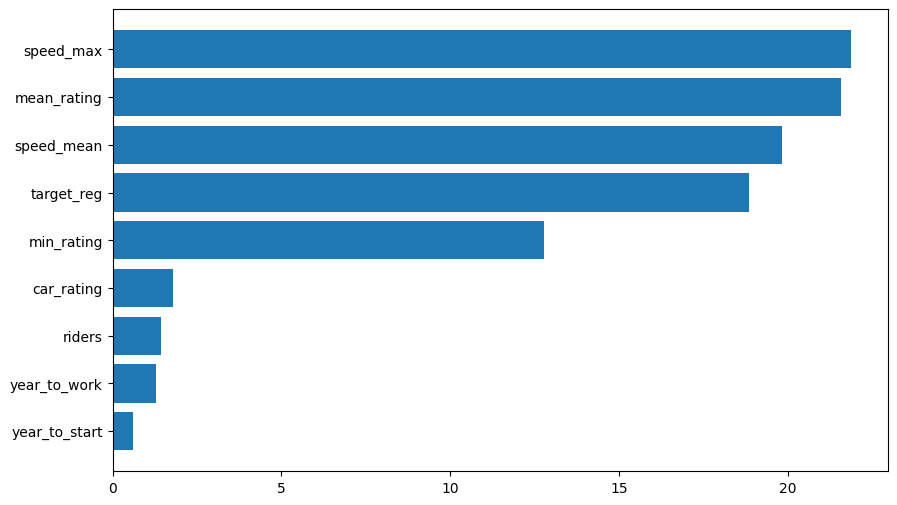

In [148]:
# Получение важности признаков
feature_importances = model.get_feature_importance()
sorted_indices = np.argsort(feature_importances)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_indices])
plt.yticks(range(len(feature_importances)), X_train.columns[sorted_indices])
plt.show()

#### **Waterfall Plot:**

In [33]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.1 MB/s eta 0:00:00


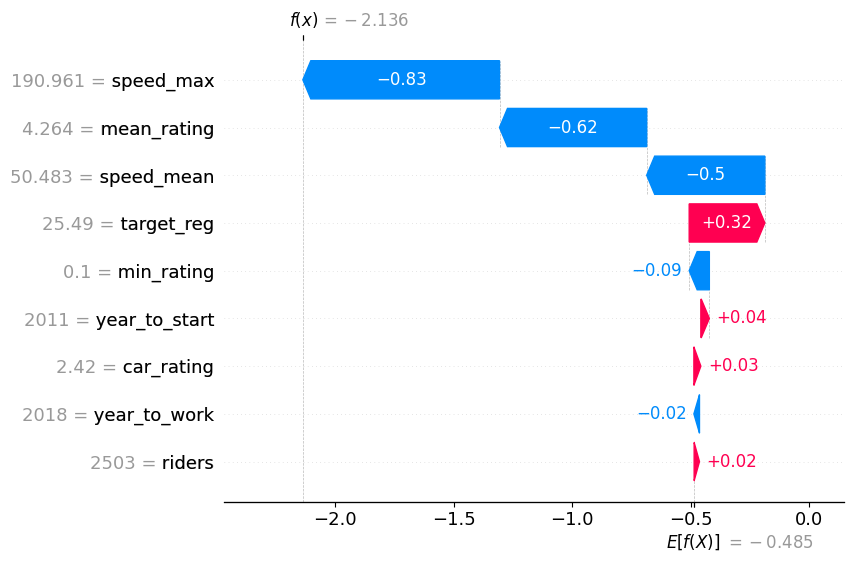

In [149]:
import shap

explainer = shap.Explainer(model=model)
shap_values = explainer(X_test)

shap.plots.waterfall(shap_values[0,:,1])

#### **Classification Report**

In [150]:
from sklearn.metrics import classification_report
report = classification_report(y_test, predictions)
print(report)

                 precision    recall  f1-score   support

    another_bug       0.90      0.97      0.93        58
      break_bug       1.00      1.00      1.00        60
    electro_bug       1.00      1.00      1.00        47
   engine_check       0.90      0.88      0.89        42
    engine_fuel       0.85      0.77      0.81        52
engine_ignition       0.84      0.78      0.81        59
engine_overheat       0.71      0.81      0.76        52
     gear_stick       0.98      0.95      0.97        62
    wheel_shake       0.92      0.94      0.93        36

       accuracy                           0.90       468
      macro avg       0.90      0.90      0.90       468
   weighted avg       0.90      0.90      0.90       468



#### **Confusion Matrix**

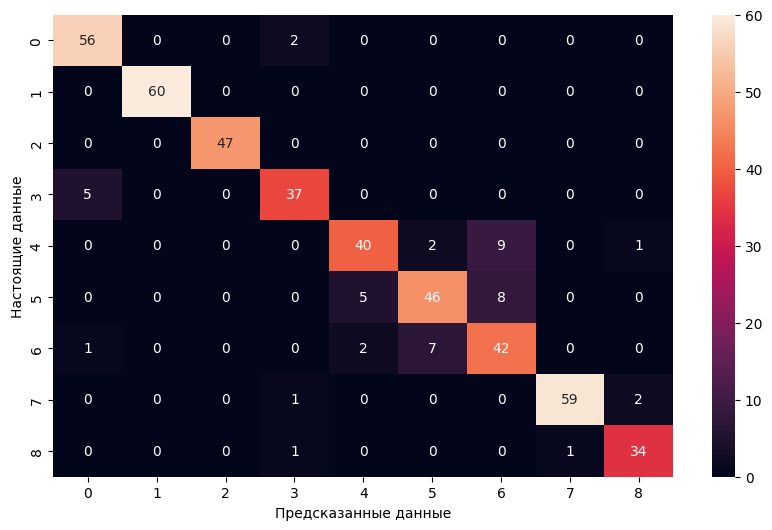

In [151]:
from sklearn.metrics import confusion_matrix
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix, annot=True)
plt.xlabel('Предсказанные данные')
plt.ylabel('Настоящие данные')
plt.show();

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   model          2337 non-null   object 
 1   car_type       2337 non-null   object 
 2   fuel_type      2337 non-null   object 
 3   car_rating     2337 non-null   float64
 4   year_to_start  2337 non-null   int64  
 5   riders         2337 non-null   int64  
 6   year_to_work   2337 non-null   int64  
 7   target_reg     2337 non-null   float64
 8   target_class   2337 non-null   object 
 9   min_rating     2337 non-null   float64
 10  mean_rating    2337 non-null   float64
 11  speed_max      2337 non-null   float64
 12  speed_mean     2337 non-null   float64
dtypes: float64(6), int64(3), object(4)
memory usage: 255.6+ KB


In [38]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.0 MB/s eta 0:00:00


In [39]:
import optuna

In [47]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-9, 10),
    }

    model = CatBoostClassifier(**params, random_state=4)
    model.fit(X_train, y_train, verbose=100)

    predictions = model.predict(X_test)

    acc_score_value = sklearn.metrics.accuracy_score(y_test, predictions)

    return acc_score_value

In [43]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

In [ ]:
best_params = study.best_params
best_params

{'iterations': 711,
 'learning_rate': 0.0905851314864452,
 'depth': 4,
 'l2_leaf_reg': 9.65082702367431}

In [ ]:
best_model = CatBoostClassifier(**best_params, random_state=4)
best_model.fit(X_train, y_train, verbose=100)

0:	learn: 1.9372116	total: 4.29ms	remaining: 3.04s
100:	learn: 0.3153528	total: 379ms	remaining: 2.29s
200:	learn: 0.2632571	total: 756ms	remaining: 1.92s
300:	learn: 0.2359854	total: 1.14s	remaining: 1.55s
400:	learn: 0.2159646	total: 1.56s	remaining: 1.21s
500:	learn: 0.2011868	total: 1.97s	remaining: 826ms
600:	learn: 0.1875347	total: 2.38s	remaining: 435ms
700:	learn: 0.1749521	total: 2.77s	remaining: 39.4ms
710:	learn: 0.1735758	total: 2.81s	remaining: 0us


In [ ]:
predicts = best_model.predict(X_test)
accuracy2 = sklearn.metrics.accuracy_score(y_test, predicts)
round(accuracy2, 3)

0.91

#### **Вывод:**
Метрика Accuracy стала выше, что выглядит отлично. Однако, как бы я еще не менял параметры для перебора - лучше, чем ~0.91 сделать у меня не получалось. В целом, я рад, что получилось увеличить метрику, даже на 0.01.

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

# **CatBoostClassifier**

In [77]:
import optuna

In [80]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def objective_CBC(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
    }

    model = CatBoostClassifier(**params, random_state=4)
    model.fit(X_train, y_train, verbose=100)

    predictions = model.predict(X_test)

    acc_score_value = sklearn.metrics.accuracy_score(y_test, predictions)

    return acc_score_value

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_CBC, n_trials=10)

In [87]:
best_params_CBC = study.best_params
best_params_CBC

{'iterations': 939, 'depth': 3}

In [88]:
best_model_CBC = CatBoostClassifier(**best_params_CBC, random_state=4)
best_model_CBC.fit(X_train, y_train, verbose=100)

Learning rate set to 0.086153
0:	learn: 1.9708435	total: 2.76ms	remaining: 2.59s
100:	learn: 0.3141346	total: 254ms	remaining: 2.1s
200:	learn: 0.2605303	total: 553ms	remaining: 2.03s
300:	learn: 0.2321351	total: 953ms	remaining: 2.02s
400:	learn: 0.2091547	total: 1.43s	remaining: 1.92s
500:	learn: 0.1920936	total: 1.85s	remaining: 1.62s
600:	learn: 0.1793911	total: 2.32s	remaining: 1.3s
700:	learn: 0.1672734	total: 2.82s	remaining: 958ms
800:	learn: 0.1561628	total: 3.09s	remaining: 533ms
900:	learn: 0.1457885	total: 3.36s	remaining: 142ms
938:	learn: 0.1422642	total: 3.46s	remaining: 0us


In [89]:
predicts_CBC = best_model_CBC.predict(X_test)
accuracy_CBC = sklearn.metrics.accuracy_score(y_test, predicts_CBC)
round(accuracy_CBC, 3)

0.902

# **LightGBMClassifier**

In [90]:
!pip install lightgbm

In [91]:
from lightgbm import LGBMClassifier

In [92]:
def objective_LGBMC(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'max_depth ': trial.suggest_int('max_depth', -1, 10),
    }

    model = LGBMClassifier(**params, random_state=4, silent=True)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    acc_score_value = sklearn.metrics.accuracy_score(y_test, predictions)

    return acc_score_value

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_LGBMC, n_trials=10)

In [94]:
best_params_LGBMC = study.best_params
best_params_LGBMC

{'num_leaves': 32, 'max_depth': 10}

In [ ]:
best_model_LGBMC = LGBMClassifier(**best_params_LGBMC, random_state=4)
best_model_LGBMC.fit(X_train, y_train)

In [96]:
predicts_LGBMC = best_model_LGBMC.predict(X_test)
accuracy_LGBMC = sklearn.metrics.accuracy_score(y_test, predicts_LGBMC)
round(accuracy_LGBMC, 3)

0.882

# **XGBoostClassifier**

In [97]:
!pip install xgboost

In [152]:
from xgboost import XGBClassifier

In [159]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y2 = le.fit_transform(y)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [179]:
def objective_XGBC(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2, random_state=4)

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 1, 8),
    }

    model = XGBClassifier(**params, random_state=4, booster='dart')
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    acc_score_value = sklearn.metrics.accuracy_score(y_test, predictions)

    return acc_score_value

In [180]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_XGBC, n_trials=10)

[I 2024-04-03 17:08:55,090] A new study created in memory with name: no-name-11766b96-37d2-4d87-a6f5-bb2da95fbeb8
[I 2024-04-03 17:09:03,868] Trial 0 finished with value: 0.8952991452991453 and parameters: {'learning_rate': 0.09477418779709146, 'max_depth': 1}. Best is trial 0 with value: 0.8952991452991453.
[I 2024-04-03 17:09:14,865] Trial 1 finished with value: 0.8867521367521367 and parameters: {'learning_rate': 0.0342096276462872, 'max_depth': 7}. Best is trial 0 with value: 0.8952991452991453.
[I 2024-04-03 17:09:24,974] Trial 2 finished with value: 0.8995726495726496 and parameters: {'learning_rate': 0.04840919454449947, 'max_depth': 2}. Best is trial 2 with value: 0.8995726495726496.
[I 2024-04-03 17:09:35,233] Trial 3 finished with value: 0.8803418803418803 and parameters: {'learning_rate': 0.35690050422765296, 'max_depth': 3}. Best is trial 2 with value: 0.8995726495726496.
[I 2024-04-03 17:09:46,318] Trial 4 finished with value: 0.8824786324786325 and parameters: {'learning_

In [181]:
best_params_XGBC= study.best_params
best_params_XGBC

{'learning_rate': 0.04840919454449947, 'max_depth': 2}

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2, random_state=4)
best_model_XGBC = XGBClassifier(**best_params_XGBC, random_state=4)
best_model_XGBC.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04840919454449947,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [183]:
predicts_XGBC = best_model_XGBC.predict(X_test)
accuracy_XGBC = sklearn.metrics.accuracy_score(y_test, predicts_XGBC)
round(accuracy_XGBC, 3)

0.9

# **RandomForestClassifier**

In [173]:
from sklearn.ensemble import RandomForestClassifier

In [174]:
def objective_RFC(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2, random_state=4)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 1, 8),
    }

    model = RandomForestClassifier(**params, random_state=4)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    acc_score_value = sklearn.metrics.accuracy_score(y_test, predictions)

    return acc_score_value

In [175]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_RFC, n_trials=10)

[I 2024-04-03 17:00:41,006] A new study created in memory with name: no-name-4a53153a-aee9-4c93-99fc-57678be02823
[I 2024-04-03 17:00:41,151] Trial 0 finished with value: 0.8333333333333334 and parameters: {'n_estimators': 46, 'max_depth': 3}. Best is trial 0 with value: 0.8333333333333334.
[I 2024-04-03 17:00:41,413] Trial 1 finished with value: 0.8910256410256411 and parameters: {'n_estimators': 48, 'max_depth': 6}. Best is trial 1 with value: 0.8910256410256411.
[I 2024-04-03 17:00:41,562] Trial 2 finished with value: 0.7115384615384616 and parameters: {'n_estimators': 21, 'max_depth': 2}. Best is trial 1 with value: 0.8910256410256411.
[I 2024-04-03 17:00:41,718] Trial 3 finished with value: 0.8333333333333334 and parameters: {'n_estimators': 36, 'max_depth': 3}. Best is trial 1 with value: 0.8910256410256411.
[I 2024-04-03 17:00:42,000] Trial 4 finished with value: 0.8910256410256411 and parameters: {'n_estimators': 44, 'max_depth': 8}. Best is trial 1 with value: 0.89102564102564

In [176]:
best_params_RFC= study.best_params
best_params_RFC

{'n_estimators': 48, 'max_depth': 6}

In [177]:
best_model_RFC = RandomForestClassifier(**best_params_RFC, random_state=4)
best_model_RFC.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=48, random_state=4)

In [178]:
predicts_RFC = best_model_RFC.predict(X_test)
accuracy_RFC = sklearn.metrics.accuracy_score(y_test, predicts_RFC)
round(accuracy_RFC, 3)

0.891

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.